In [1]:
%matplotlib inline
import sklearn
import pandas
import numpy
import matplotlib.pyplot as plt

import trackml.dataset
import trackml.score

import os.path
import sys

In [2]:
path_to_train = 'train_100_events.zip'
event_prefix = "event000001001"
#path = os.path.join(path_to_train, event_prefix)
path = 'train_sample.zip'

events = pandas.DataFrame()
datas = []
for e in trackml.dataset.load_dataset(path, nevents=3):
    event_id, hits, cells, particles, truth = e
    data = hits.merge(truth)
    data['event_id'] = event_id
    events = data
    datas.append(data)
events = pandas.concat(datas)

events.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,event_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000,1000
1,2,-55.336102,0.635342,-1502.5,7,2,1,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010,1000
2,3,-83.830498,-1.143010,-1502.5,7,2,1,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000,1000
3,4,-96.109100,-8.241030,-1502.5,7,2,1,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008,1000
4,5,-62.673599,-9.371200,-1502.5,7,2,1,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009,1000


In [3]:
events['event_id'].unique(), len(events)

(array([1000, 1001, 1002]), 340123)

In [4]:
len(events['layer_id'].unique()), len(events['volume_id'].unique()), len(events['module_id'].unique())

(7, 9, 3186)

In [63]:
events[events['particle_id'] == 22525763437723648]

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
1,2,-55.336102,0.635342,-1502.5,7,2,1,1000,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.4922,0.000010
1419,1420,-55.162201,0.604841,-1497.5,7,2,106,1000,22525763437723648,-55.154400,0.621779,-1497.5,-0.569794,0.027264,-15.4928,0.000008
1459,1460,-47.975498,0.311848,-1302.5,7,4,1,1000,22525763437723648,-47.988098,0.315591,-1302.5,-0.568883,0.021994,-15.4929,0.000006
3169,3170,-47.812302,0.327322,-1297.5,7,4,106,1000,22525763437723648,-47.804100,0.308733,-1297.5,-0.571445,0.020847,-15.4933,0.000005
3233,3234,-40.622799,0.088046,-1102.5,7,6,1,1000,22525763437723648,-40.626099,0.087326,-1102.5,-0.569940,0.015274,-15.4934,0.000005
5342,5343,-40.438801,0.098098,-1097.5,7,6,106,1000,22525763437723648,-40.442200,0.082538,-1097.5,-0.570204,0.013872,-15.4940,0.000006
5423,5424,-35.480598,-0.008800,-962.5,7,8,1,1000,22525763437723648,-35.475899,-0.024284,-962.5,-0.569773,0.010668,-15.4940,0.000009
5481,5482,-35.330101,-0.023294,-958.0,7,8,4,1000,22525763437723648,-35.310101,-0.027160,-958.0,-0.571644,0.008881,-15.4949,0.000011
7866,7867,-35.312302,-0.004440,-957.5,7,8,106,1000,22525763437723648,-35.291698,-0.027451,-957.5,-0.571617,0.009012,-15.4950,0.000014
7950,7951,-30.333700,-0.105277,-822.5,7,10,1,1000,22525763437723648,-30.315399,-0.095482,-822.5,-0.570993,0.006231,-15.4951,0.000016


In [6]:
events.columns

Index(['hit_id', 'x', 'y', 'z', 'volume_id', 'layer_id', 'module_id',
       'particle_id', 'tx', 'ty', 'tz', 'tpx', 'tpy', 'tpz', 'weight',
       'event_id'],
      dtype='object')

In [4]:
def make_pairs(df):
    p = (df.merge(df, on=df.assign(key_col=1)['key_col'], suffixes=('_a', '_b'))
      .query('hit_id_b != hit_id_a') # filter out joins on the same row
      .reset_index(drop=True))
    return p

In [6]:
# Sample hits for training, a mix of hits from same track and from different
# TODO: allow to specify mix, instead of assuming 50%
def training_sample(hits, n_particles, n_hits, random_state=None):
    hits = events
    particles = hits['particle_id'].sample(n=n_particles, random_state=random_state)
    samples = []
    for particle in particles:
        matches = hits[hits['particle_id'] == particle].sample(n=n_hits, replace=True, random_state=random_state)
        #nonmatches = hits[hits['particle_id'] != particle].sample(n=n_hits//2, replace=True, random_state=random_state)
        samples.append(matches)
        #samples.append(nonmatches)

    samples = pandas.concat(samples)
    return samples

t = training_sample(events, 20, 20)
t.shape

(400, 16)

In [7]:
pairs = make_pairs(t)

In [8]:
def pair_features(pairs): 
    features = pandas.DataFrame()

    # rough proxies of
    features['volume_diff'] = pairs['volume_id_a'] - pairs['volume_id_b']
    features['layer_diff'] = pairs['layer_id_a'] - pairs['layer_id_b']
    features['module_diff'] = pairs['module_id_a'] - pairs['module_id_b']
    
    return features

data = pair_features(pairs)
data['matches'] = pairs['particle_id_a'] == pairs['particle_id_b']
data.head(n=10)

,volume_diff,layer_diff,module_diff,matches
0,0,-4,0,True
1,6,2,-294,True
2,6,4,-24,True
3,5,-4,56,True
4,0,-4,-3,True
5,6,4,-24,True
6,5,-4,56,True
7,5,4,60,True
8,5,4,60,True
9,5,-2,56,True


In [9]:
from sklearn import model_selection, metrics

test_size = 0.3
seed = 1

target_columns = ['matches']
data_columns = list(set(data.columns) - set(target_columns))

s = model_selection.train_test_split(data[data_columns], data[target_columns], test_size=test_size, random_state=seed)
X_train, X_test, Y_train, Y_test = s
Y_train = Y_train['matches']
Y_test = Y_test['matches']

In [21]:
# From http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=numpy.linspace(.1, 1.0, 5), metric=None):
    np = numpy
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    s = model_selection.learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=metric)
    train_sizes, train_scores, test_scores = s
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [22]:
def plot_forest_importance(forest, X):
    importances = forest.feature_importances_
    std = numpy.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = numpy.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %d : %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]), )

    # Plot the feature importances of the forest
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title("Feature importances")
    ax.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    #ax.set_xticks(range(X.shape[1]), indices)
    #ax.set_xlim([-1, X.shape[1]])
    return fig

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] min_samples_split=0.1, n_estimators=10 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=10, total=   1.0s
[CV] min_samples_split=0.1, n_estimators=10 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ........... min_samples_split=0.1, n_estimators=10, total=   1.0s
[CV] min_samples_split=0.1, n_estimators=10 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=10, total=   1.0s
[CV] min_samples_split=0.1, n_estimators=20 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=20, total=   1.9s
[CV] min_samples_split=0.1, n_estimators=20 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=20, total=   1.8s
[CV] min_samples_split=0.1, n_estimators=20 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=20, total=   1.8s
[CV] min_samples_split=0.1, n_estimators=40 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=40, total=   3.8s
[CV] min_samples_split=0.1, n_estimators=40 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=40, total=   3.6s
[CV] min_samples_split=0.1, n_estimators=40 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.5min finished


Using parameters {'min_samples_split': 0.01, 'n_estimators': 40}
Test set score: 0.96%


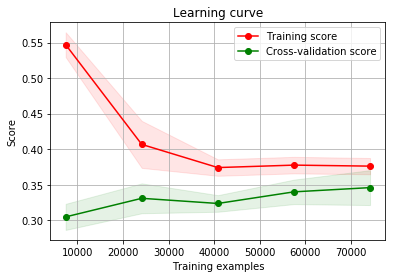

In [23]:
from sklearn.ensemble import RandomForestClassifier

metric = 'average_precision'

estimator = RandomForestClassifier()
parameters = {
    'n_estimators': [ 10, 20, 40, 80 ],
    'min_samples_split': [ 0.5, 0.01, 0.05 ],
}
search = model_selection.GridSearchCV(estimator, parameters, cv=3, verbose=2, scoring=metric)
search.fit(X_train, Y_train)

# Evaluation
print('Using parameters', search.best_params_)

plot_learning_curve(search.best_estimator_, 'Learning curve', X_train, Y_train, metric=metric)

score = metrics.get_scorer(metric)(search.best_estimator_, X_test, Y_test)
print('Test set score: %.2f' % (score,))

In [34]:
precision = metrics.get_scorer('precision')(search.best_estimator_, X_test, Y_test)
recall = metrics.get_scorer('recall')(search.best_estimator_, X_test, Y_test)
precision, recall

(0.6836734693877551, 0.09548693586698337)

Feature ranking:
1. 1 : module_diff (0.709085)
2. 0 : volume_diff (0.247729)
3. 2 : layer_diff (0.043186)


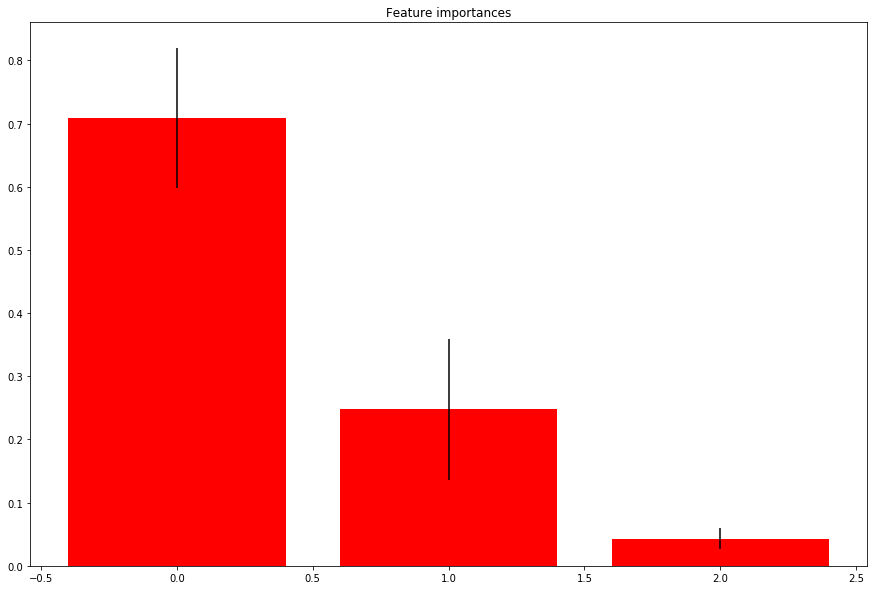

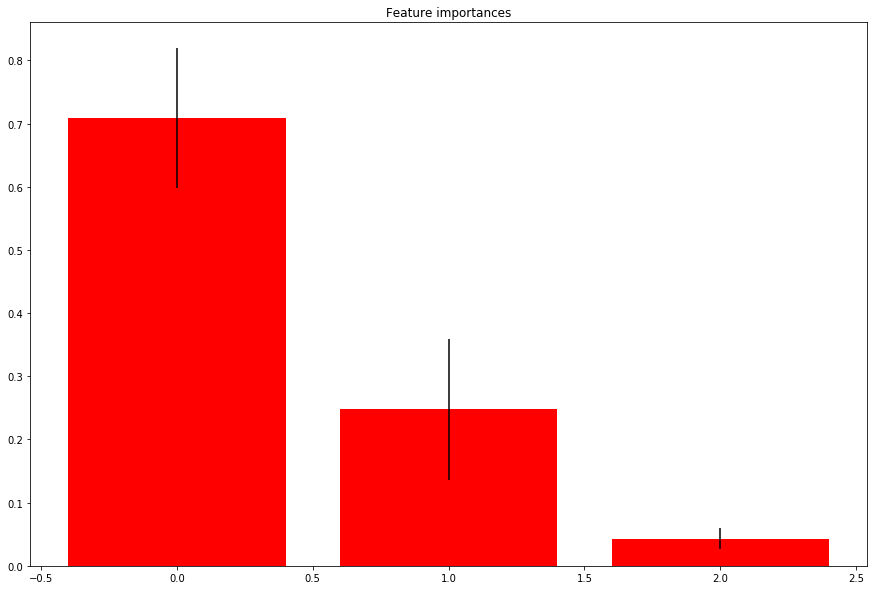

In [24]:
plot_forest_importance(search.best_estimator_, X_train)